# Dimension Reduction on Images

Large data sets like images and audio potentially have enourmous number of features. Each pixel of an image is potentially a separate feature. We have seen in discussions of feature selection that this could be dealt, in some cases, by feature selection. If we have many features we can eliminate those that are not relavant. But if we are talking about pixels of an image, it is much harder to decided which pixel location, across all images, is a useful feature. Rather it is probably more likely the case that aggregate features such as mean pixel level, standard deveation of pixel level, color histograms, counts of edge pixels, could provide more robust features. Dimension reduction will give us some techniques here to find feature for

* Visulaliztion
* Denoising
* Reducing unecessaring computation

And matny more. We will work with an image data set of apples. Our task will be to label the ables. Actually although the data set has over 7000 images, many of the images are of the same apples rotated.
 <br>
 <center><img src='./apples-grid.png' width=340></center><br>


## Import all our Libraries
The first step is to import our libraries. The usual suspects are all here, numpy, pandas, seaborn and matplotlib. Let me call out three I have not mentioned before.

### Imageio

There has been some image processing in numpy then in scipy for reading images and also PIL which was forked to pillow. Some of this functionality was moved again to scikit-image. Now they have factor out image reading into a separate library imageio which is **only** for reading and writing images. It handles a number of image formats as well as some medical and satellite formats. This is not the preferred way of pulling your images in, even thoug matplotlib, scikit-image, and pillow also have interfaces.

### os, os.path

We have not worked with these libraries much. These are standard python libraries and as such are part of the swiss knife of python. All the operations you might want to do, reading, writing files, finding information like how big they are, deleting files, getting lists of filds ... are all handled by os and os.path. One tends to use os.path to manipulate the file names themselves and to get information, while os has the heavy lifting in terms of actual creating and deleting files.

## re

The regular expression library comes in handing very very often. You should know it particuarly for getting patterns out of file entrys, file names and for generating file names.

In [1]:
import numpy as np
import os
import os.path as op
import re
import pandas as pd
import imageio
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score

plt.style.use('ggplot')
%matplotlib inline

## Part 1: Loading and formatting Data and MetaData

In this part you are going to use the os and os.path libraries, pandas, and imageio to set up your data. This project will eat lots of memory and you will have occasion to start and stop. You are going to run through all the files and create a pandas data structure so you have the id number of the image, and the label which is stored in the file name.

It is idiotic to keep generating this data each time you want to do an analysis. Once you figured this out you don't want to redo it. So you will set up a number of save-files. One for the table which will hold index, file names and labels. One which will hold the actual image data in a great big matrix. You will need if statements that check if you have build these files succesfully. This way when you run the notebook again, if the files are available you read them from disk but if not you build them and save them to disk so that next time you can just read them. 

This will be particularly important later when you run experiments that can die for unknown reasons. You want to set up checkpoints in your preprocessing so that if your machine goes down, or if amazon cuts your time or whatever, you don't lose the work you have already completed. 

By the way, before you write any code you should flip through as many images as you can. You should look at some at the start, some in the middle, some later on. Jump around. Do your own random sample. Get familiar with what they look like and what the file names look like. 


### Specify our Data Directory and Dat Savefile

In [11]:
# Here you can set up you paths
data_dir = '/Users/carlostavarez/Desktop/DSE/Machine_Learning/Hm/data/ApplesCorrupted'
df_savefile = '/Users/carlostavarez/Desktop/DSE/Machine_Learning/Hm/apple_dataframe.csv'

not_df_cached = not op.exists(df_savefile) # If savefile is around, this variable says if to skip
#not_cached = True # override caching
print(not_df_cached)

False


### Getting File Names and Parsing to Data Frame

In this section you will use if statements so you can load from disk after you parsed the filees. You are going to want to use os.listdir to get all the files. You should write a function called parse_filename that takes a file name string and returns 

* the number
* the class label string without the number on the end eg. "Apple Braeburn" or "Apple Granny Smith"
* the filename

You can then use this function to efficiently create a data frame which has those three attributes as columns using the number as the index. Afterward you will cache (save) this table to disk as a csv file so that next time you run the notebook it can just read that from disk. Make sure you open the csv file and check it in excel or libre office to make sure it looks good.

In [3]:
def parse_filename(fname):
    """Utility function to parse file name into ID number, target and filename"""
    m = re.match(r'([0-9]+).(\D*).*', fname)
    if m:
        idnum, target = m.group(1).strip(), m.group(2).strip()
    else:
        print('Match Failed:',fname)
    return idnum, target, fname

In [4]:
filenames = list(set(os.listdir(data_dir)))

In [5]:
len(filenames)

7354

In [6]:
filenames[:10]

['3875-Apple Red 1.jpg',
 '4944-Apple Red 3.jpg',
 '1281-Apple Golden 1.jpg',
 '2601-Apple Golden 3.jpg',
 '5934-Apple Red Yellow 1.jpg',
 '2050-Apple Golden 3.jpg',
 '7293-Apple Red Yellow 2.jpg',
 '4815-Apple Red 3.jpg',
 '3807-Apple Red 1.jpg',
 '5136-Apple Red 3.jpg']

In [7]:
if not_df_cached:
    parsed_fnames = [parse_filename(fname) for fname in filenames]

parsed_fnames[:10]

[('3875', 'Apple Red', '3875-Apple Red 1.jpg'),
 ('4944', 'Apple Red', '4944-Apple Red 3.jpg'),
 ('1281', 'Apple Golden', '1281-Apple Golden 1.jpg'),
 ('2601', 'Apple Golden', '2601-Apple Golden 3.jpg'),
 ('5934', 'Apple Red Yellow', '5934-Apple Red Yellow 1.jpg'),
 ('2050', 'Apple Golden', '2050-Apple Golden 3.jpg'),
 ('7293', 'Apple Red Yellow', '7293-Apple Red Yellow 2.jpg'),
 ('4815', 'Apple Red', '4815-Apple Red 3.jpg'),
 ('3807', 'Apple Red', '3807-Apple Red 1.jpg'),
 ('5136', 'Apple Red', '5136-Apple Red 3.jpg')]

In [8]:
df = pd.DataFrame(parsed_fnames, columns=['number', 'target', 'fname'])
df.number = pd.to_numeric(df.number)
df = df.sort_values(['number'])
df = df.set_index(['number'])
df.head(10)

,target,fname
number,,
0,Apple Braeburn.jpg,0-Apple Braeburn.jpg
1,Apple Braeburn.jpg,1-Apple Braeburn.jpg
2,Apple Braeburn.jpg,2-Apple Braeburn.jpg
3,Apple Braeburn.jpg,3-Apple Braeburn.jpg
4,Apple Braeburn.jpg,4-Apple Braeburn.jpg
5,Apple Braeburn.jpg,5-Apple Braeburn.jpg
6,Apple Braeburn.jpg,6-Apple Braeburn.jpg
7,Apple Braeburn.jpg,7-Apple Braeburn.jpg
8,Apple Braeburn.jpg,8-Apple Braeburn.jpg


In [12]:
if not_df_cached:
    df.to_csv(path_or_buf=df_savefile)
else:
    df = pd.read_csv(df_savefile)

df.head(15)

,number,target,fname
0,0,Apple Braeburn.jpg,0-Apple Braeburn.jpg
1,1,Apple Braeburn.jpg,1-Apple Braeburn.jpg
2,2,Apple Braeburn.jpg,2-Apple Braeburn.jpg
3,3,Apple Braeburn.jpg,3-Apple Braeburn.jpg
4,4,Apple Braeburn.jpg,4-Apple Braeburn.jpg
5,5,Apple Braeburn.jpg,5-Apple Braeburn.jpg
6,6,Apple Braeburn.jpg,6-Apple Braeburn.jpg
7,7,Apple Braeburn.jpg,7-Apple Braeburn.jpg
8,8,Apple Braeburn.jpg,8-Apple Braeburn.jpg
9,9,Apple Braeburn.jpg,9-Apple Braeburn.jpg


### Getting number of images and number of rows, cols and chans of a sample image

Now we can start the process of building a data file which will hold all the data for all our images in one mult-array. This will be more convenient for doing analysis. First check we didn't do it already and save to disk. Like before we can create a save file

apple_images_savefile = './apple_images.npy'

and a variable "apple_images_not_cached" for the case where we loaded from disk, or we have to rebuild. Load at least one image from disk which you get from the table we created before. Also count the number of images. From this we can get "num_ims", "num_rows", "num_cols", and "num_chans" ... you should print something like this:

num_ims: 7354, num_rows: 100, num_cols: 100, num_chans: 3

In [13]:
# lotsa stuff

# checking if file it's not already saved
apple_images_savefile = '/Users/carlostavarez/Desktop/DSE/Machine_Learning/Hm/apple_images.npy'

apple_images_not_cached = not op.exists(apple_images_savefile) 
print(apple_images_not_cached)

False


In [14]:
files = df.fname.values

path = '/Users/carlostavarez/Desktop/DSE/Machine_Learning/Hm/data/ApplesCorrupted/{}'
img = imageio.imread(path.format(files[0]))
img.shape

num_ims = len(files)
num_rows = img.shape[0]
num_cols = img.shape[1]
num_chans = img.shape[2]

print("num_ims: {}, num_rows: {}, num_cols: {}, num_chans: {}".format(num_ims,
                                                                      num_rows,
                                                                      num_cols,
                                                                      num_chans))

num_ims: 7354, num_rows: 100, num_cols: 100, num_chans: 3


### Loading all the image data into a great big numpy array by index number

Now if you haven't built the data structure of images yet (because it was already cached on disk), here is where it is built and saved. First create a 4 dimensional numpy array (image number, rows, cols, channels) to hold the data, then loop through the list of files from the pandas dataframe, inserting each image at the index indicated from the number column. Before you load in the data divide by 255. so the numbers are floating point numbers that go from 0 to 1 rather than 0 to 255. Makes sure the number at the beginning of the file name corresponds to the first index in the multi-array. Then use "numpy.save" to save out a ".npy" file.

In [15]:
# lotsa stuff
image_array = np.zeros((num_ims, num_rows, num_cols, num_chans))
print(image_array.shape)

(7354, 100, 100, 3)


In [16]:
for number, file in zip(df.index, df.fname.values):
    img = imageio.imread(path.format(file))/255.0
    image_array[number, :, :, :] = img

In [17]:
if apple_images_not_cached:
    np.save(apple_images_savefile, image_array)
else:
    image_array = np.load(apple_images_savefile)
    

## Part 2: EDA and Data Cleaning

As usual we should do some EDA here. For various reasions it is easier to work with 0 to 1 with 256 levels rather than 0 to 255. Make a few histograms but it may be usefule to make three 1-D red_pixels, green_pixels, and blue_pixels arrays that have num_ims*num_rows*num_cols elements. You can do this on the fly when you need to (might be slower but easier on memory then to hold another copy of the data.

### 2-Histogram between Channels

Here we just want to look to see the relationships using "plt.hist2d" with 25 bins nd seperately between red and green, red and blue, and green and blue pixels. When we make a 2d histogram (with 25 bins) it is going to be dominated by the "white" or close to "white pixels". You will probably not see much but a bright pixel in the upper right corner which is the white pixel. You need to set your bins manually like so:

bins=(np.linspace(0,250/255,26),np.linspace(0,250/255,26))

so that you are ignoring the white pixels which aren't even on the apples anyhow. What you should see just above .2 (close to 50/255 gray level) is a bright spot. This will be on the diagonal which means that red=green or blue=green or red=blue. One such case is red=green=blue which indicates a white, gray or black pixel. Indeed if you flipped through the apple pictures you should have seen a few weird gray noisey images. 


In [18]:
image_array = image_array.reshape((num_ims*100*100, 3))

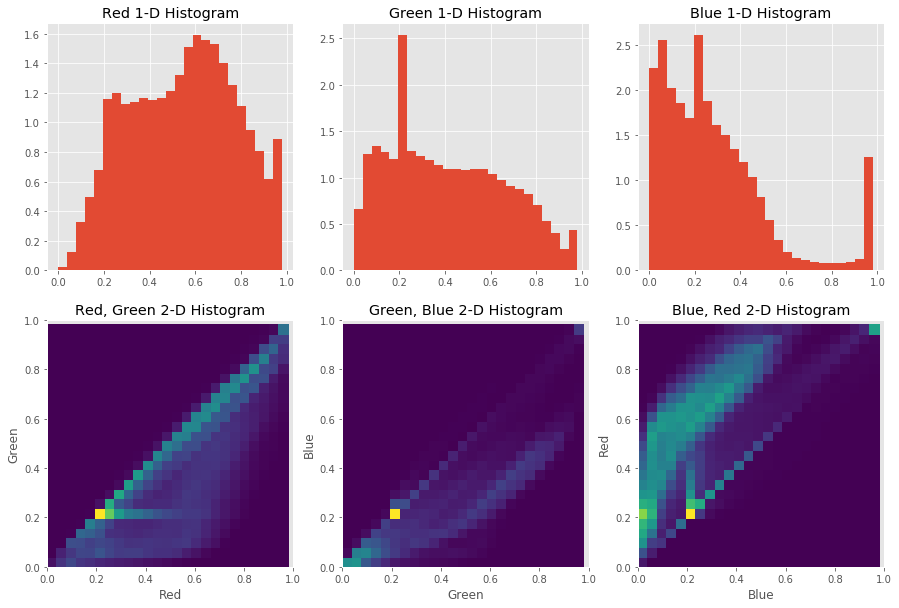

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

ax[0,0].hist(image_array[:, 0], bins=(np.linspace(0,250/255,26)), density=True)
ax[0,0].set_title("Red 1-D Histogram")

ax[0,1].hist(image_array[:, 1], bins=(np.linspace(0,250/255,26)), density=True)
ax[0,1].set_title("Green 1-D Histogram")

ax[0,2].hist(image_array[:, 2], bins=(np.linspace(0,250/255,26)), density=True)
ax[0,2].set_title("Blue 1-D Histogram")

ax[1,0].hist2d(image_array[:, 0], image_array[:, 1], bins=(np.linspace(0,250/255,26), np.linspace(0,250/255,26)))
ax[1,0].set_title("Red, Green 2-D Histogram")
ax[1,0].set_xlabel('Red')
ax[1,0].set_ylabel('Green')
ax[1,0].set_xlim([0,1])
ax[1,0].set_ylim([0,1])

ax[1,1].hist2d(image_array[:, 1], image_array[:, 2], bins=(np.linspace(0,250/255,26), np.linspace(0,250/255,26)))
ax[1,1].set_title("Green, Blue 2-D Histogram")
ax[1,1].set_xlabel('Green')
ax[1,1].set_ylabel('Blue')
ax[1,1].set_xlim([0,1])
ax[1,1].set_ylim([0,1])

ax[1,2].hist2d(image_array[:, 2], image_array[:, 0], bins=(np.linspace(0,250/255,26), np.linspace(0,250/255,26)))
ax[1,2].set_title("Blue, Red 2-D Histogram")
ax[1,2].set_xlabel('Blue')
ax[1,2].set_ylabel('Red')
ax[1,2].set_xlim([0,1])
ax[1,2].set_ylim([0,1])

plt.show()

### Stop the run at a point

There will be times when you want to stop the run at a certain point. There ware ways to select cells but sometimes it is easier to drop a cell with a ZeroDivisionError and tell it to run all cells. This will stop it at the error and you can continue manually afterward.

In [22]:
#1/0

### Exploration of Means/Stddevation leads find blue channels std dev shows bad images

By inspection and EDA we see that roughly 5% of the images are corrupted. This could be on account of a faulty camera sensor. Since the data are *missing completely at random*, the best course of action is to remove them entirely so that our model is not adversely affected. Ideally we would like to see if there is a cheap way to identify the indices that correspond to the bad images so we can disregard them. Each image has three channels and if we could compute some stats of those images that basically told us they were a noise image, that would be idea. The two of the most simple stats we can think of are mean and standard deviation. Compute 6 scatter plots in a 2x6 array of figures. 

For all of these subplots, the X axis is the index from 0 to 7353 indicating which image we are talking about. For the top three, we will have the image mean for red (column 1), green (column 2) and blue (column 3). For the bottom row it will be the same but for standard deviation and we are looking at **scatter plots** because there is no natural continuity between one image and the next. At least none was assumed. 

In [24]:
# lotsa stuff
image_array = image_array.reshape((num_ims, 100*100, 3))
np.mean(image_array[:,:,0])
num_ims
red_mean = []
blue_mean = []
gree_mean = []

red_std = []
blue_std = []
gree_std = []

for i in np.arange(num_ims):
    # red
    red_mean.append(np.mean(image_array[i,:,0]))
    red_std.append(np.std(image_array[i,:,0]))
    
    #green
    gree_mean.append(np.mean(image_array[i,:,1]))
    gree_std.append(np.std(image_array[i,:,1]))
    
    #blue
    blue_mean.append(np.mean(image_array[i,:,2]))
    blue_std.append(np.std(image_array[i,:,2]))

SCATTERPLOTS for the Mean and STD of all 3 channels


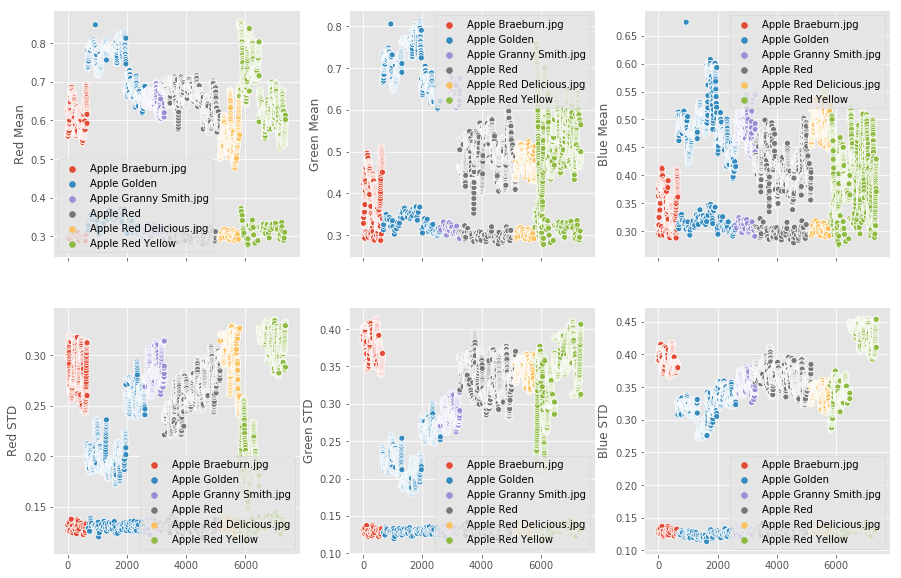

In [26]:
#plt.figure(1)

fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
print("SCATTERPLOTS for the Mean and STD of all 3 channels")
sns.scatterplot(range(num_ims), red_mean, ax=ax[0, 0], hue=df.target.values)
ax[0, 0].set_ylabel('Red Mean')

sns.scatterplot(np.arange(num_ims), gree_mean, ax=ax[0, 1], hue=df.target.values)
ax[0, 1].set_ylabel('Green Mean')

sns.scatterplot(np.arange(num_ims), blue_mean, ax=ax[0, 2], hue=df.target.values)
ax[0, 2].set_ylabel('Blue Mean')

sns.scatterplot(np.arange(num_ims), red_std, ax=ax[1, 0], hue=df.target.values)
ax[1, 0].set_ylabel('Red STD')

sns.scatterplot(np.arange(num_ims), gree_std, ax=ax[1, 1], hue=df.target.values)
ax[1, 1].set_ylabel('Green STD')

sns.scatterplot(np.arange(num_ims), blue_std, ax=ax[1, 2], hue=df.target.values)
ax[1, 2].set_ylabel('Blue STD')


plt.show()

****

I think a good starting point to separate the classes woud be to skip the data that lies below the standard deviation of the red channel.

Key here is that for many of the images you will see kind of what looks like a jumpy blobs on top (means and standard deviations that bounce around accross ad pretty large range) but a "cluster of images" which for some of these scatter plots is definitely well separated for the rest. In other words one or more of these plots will tall you if you threshold the mean or the standard deviation for of the pixels in a particular channel, you can easily separate this cluster out. What you need to do here is use numpy indices to look at some of the images in this cluster. You will fast see that the images in this cluster are all the bad noise images and the other stuff (which forms more irregular clusters) are the good images.

### Data Cleaning by Finding and Removing Bad Images

Now there a few thresholds for means or standard deviations that will work. There is ONE that has the biggest gap between the good images and the bad images, but if you use one of the other thresholds that is ok. You are going to use numpy fancing indexing preferabley, to create a new dataframe csv file, and a new numpy data file. We could call these the "apple_ok_im_dataframe.csv" and the "ok_apple_images.npy". In the dataframe for the "apple_ok_im_dataframe.csv" the index will only show the indices of images that are **not** noisy images, all we are doing is dropping rows. For example it will have image 0, 1, 2,...4 but not 5. It should also be missing image 10 ... etc. You will carefully construct "ok_apple_images.npy" so that the 6th image (index 5 in the multi-array) is really the image corresponding to "6-Apple Braeburn.jpg" even though in the prior array it would be "5-Apple Braeburn.jpg" because that is a bad noise image. 

Again we have if statements here so that all the work of building the data is cached so as we try different things, we can load them only if we didn't make them, or we want to do them over.

In [78]:
# lotsa stuff
indexes = {}

#index = blue_std[blue_std < 0.37]
for index, value in enumerate(red_std):
    if value > 0.15:
        indexes[index] = value
        

In [79]:
apple_ok_im_dataframe = df.loc[indexes.keys(), :]
apple_ok_im_dataframe = apple_ok_im_dataframe.sort_values(['number'])
apple_ok_im_dataframe.head(15)

,number,target,fname
0,0,Apple Braeburn.jpg,0-Apple Braeburn.jpg
1,1,Apple Braeburn.jpg,1-Apple Braeburn.jpg
2,2,Apple Braeburn.jpg,2-Apple Braeburn.jpg
3,3,Apple Braeburn.jpg,3-Apple Braeburn.jpg
4,4,Apple Braeburn.jpg,4-Apple Braeburn.jpg
6,6,Apple Braeburn.jpg,6-Apple Braeburn.jpg
7,7,Apple Braeburn.jpg,7-Apple Braeburn.jpg
8,8,Apple Braeburn.jpg,8-Apple Braeburn.jpg
9,9,Apple Braeburn.jpg,9-Apple Braeburn.jpg
11,11,Apple Braeburn.jpg,11-Apple Braeburn.jpg


In [4]:
apple_ok_df_savefile = '/Users/carlostavarez/Desktop/DSE/Machine_Learning/Hm/apple_ok_im_dataframe.csv'

apple_ok_df_not_cached = not op.exists(apple_ok_df_savefile) 
print(apple_ok_df_not_cached)

False


In [5]:
if apple_ok_df_not_cached:
    apple_ok_im_dataframe.to_csv(path_or_buf=apple_ok_df_savefile)
else:
    apple_ok_im_dataframe = pd.read_csv(apple_ok_df_savefile)

#apple_ok_df_savefile = apple_ok_df_savefile.set_index(df.number)

apple_ok_im_dataframe = apple_ok_im_dataframe.sort_values(['number'])
apple_ok_im_dataframe.head(15)

,number,target,fname
0,0,Apple Braeburn.jpg,0-Apple Braeburn.jpg
1,1,Apple Braeburn.jpg,1-Apple Braeburn.jpg
2,2,Apple Braeburn.jpg,2-Apple Braeburn.jpg
3,3,Apple Braeburn.jpg,3-Apple Braeburn.jpg
4,4,Apple Braeburn.jpg,4-Apple Braeburn.jpg
5,6,Apple Braeburn.jpg,6-Apple Braeburn.jpg
6,7,Apple Braeburn.jpg,7-Apple Braeburn.jpg
7,8,Apple Braeburn.jpg,8-Apple Braeburn.jpg
8,9,Apple Braeburn.jpg,9-Apple Braeburn.jpg
9,11,Apple Braeburn.jpg,11-Apple Braeburn.jpg


In [27]:
apple_ok_images_savefile = '/Users/carlostavarez/Desktop/DSE/Machine_Learning/Hm/ok_apple_images.npy'

apple_ok_images_not_cached = not op.exists(apple_ok_images_savefile) 
print(apple_ok_images_not_cached)

False


In [7]:
ok_apple_images = image_array[apple_ok_im_dataframe.index, :, :]
ok_apple_images.shape

(6946, 100, 100, 3)

In [28]:
if apple_ok_images_not_cached:
    np.save(apple_ok_images_savefile, ok_apple_images)
else:
    ok_apple_images = np.load(apple_ok_images_savefile)

In [29]:
ok_apple_images.shape

(6946, 100, 100, 3)

In [30]:
del image_array

### Deleting data structures for memory
This analysis is going to be a memory hog. After you realize you are not going to use an array again you can call the array with "del" in front to delete it. This will save the memory. For example by now we are only going to have a multiarray such as "ok_apple_images" whereas earlier we had "apple_images" which was a little bigger and had the noise images. We can now call:

del apple_images

because we don't need that any more. We only need the clean data multi-array "ok_apple_images" and the clean data frame which we dropped the bad rows.


## Part 3: Dimension Reduction on Data

Some might argue running PCA and visualizing our classes could be part of EDA. Perhaps. In anycase that is what we are going to do now. We are going to run PCA and look at the 2D scatter plots of the first components, where we color the dots using the class labels. We should have *6* class labels. If you have more go back to parsing and make sure you have just "Apple Red" and **not** "Apple Red 1", "Apple Red 2", etc. 

With dimension reduction we often don't know how many coponents we want and we want to try a range of numbers. One nice thing about PCA is we could start with a large number, we will start with n_components=200, and we won't have to recompute PCA if we want to look at 2 or 3 components, we just take the first 2 or three of the 200. Just for starters we wont normalize and we just run PCA.

### Vanalla PCA

Here reshape once and for all the data into "X" which will have shape (num_ok_ims,num_rows*num_cols*num_chans). Then run PCA with 200 components and project it. We are going to be trying different PCA/ICA and different normalizations. It is easy to keep writing something like pca=PCA() and calling each projection Xproj or something similar. **Don't!** As you go back and forth you will get very messed up as to what you are looking at. Each experiment give the tranformer a *different* name and the projected *X* a different name. Title your figs, and the x and y axis ALWAYS.

Here project to 200 and create 

* 2 *scatter plots* using seaborn (hue = labels) one will be component 1 vs component 2, a second will be component 2 vs 3.
* A variance plot. Here you take the 100* cumulative sum of the "pca_transform.explained_variance_" and divide by the sum of "pca_transform.explained_variance_". This tells us what percent of the variance is explained by that many components. The curve should start low (below 30%) and go up to close to 100%.
* A visualization of the first 4 components themselves. The first componet is in "pca_transform.components_[0,:]". If you look at the size of that it should be an array of length num_rows*num_cols*num_chans. In other words it should reshape to a color image. The only thing is that the values are going to be all over the place. To diplay the images they should take all the values and remap them using MinMaxScaler. You may need to first reshape to ".reshape(-1,1)" before feeding to the MinMaxScaler and then reshape again to an image (num_rows,num_cols,num_chans). Make each of the  first four components into color images.

In [31]:
apple_ok_im_dataframe['target'].value_counts()

Apple Golden               1846
Apple Red                  1787
Apple Red Yellow           1455
Apple Granny Smith.jpg      623
Apple Braeburn.jpg          620
Apple Red Delicious.jpg     615
Name: target, dtype: int64

In [32]:
num_ok_ims = ok_apple_images.shape[0]
num_ok_ims

6946

In [33]:
X = ok_apple_images.reshape(num_ok_ims,num_rows*num_cols*num_chans)

In [34]:
X.shape

(6946, 30000)

In [35]:
n_components = 200
pca_transform = PCA(n_components=n_components)

In [36]:
x = pca_transform.fit_transform(X)

In [38]:
X.shape, x.shape, pca_transform.components_.shape

((6946, 30000), (6946, 200), (200, 30000))

In [39]:
apple_ok_im_dataframe.target.values

array(['Apple Braeburn.jpg', 'Apple Braeburn.jpg', 'Apple Braeburn.jpg',
       ..., 'Apple Red Yellow', 'Apple Red Yellow', 'Apple Red Yellow'],
      dtype=object)

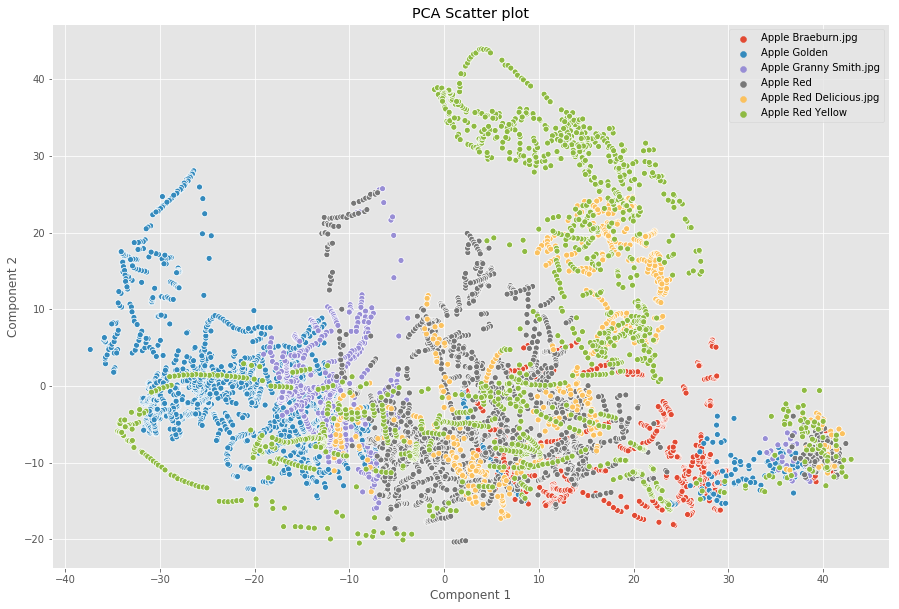

In [52]:
plt.subplots(figsize=(15,10))
sns.scatterplot(x[:,0], x[:,1], hue=apple_ok_im_dataframe['target'].values)
plt.title('PCA Scatter plot')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

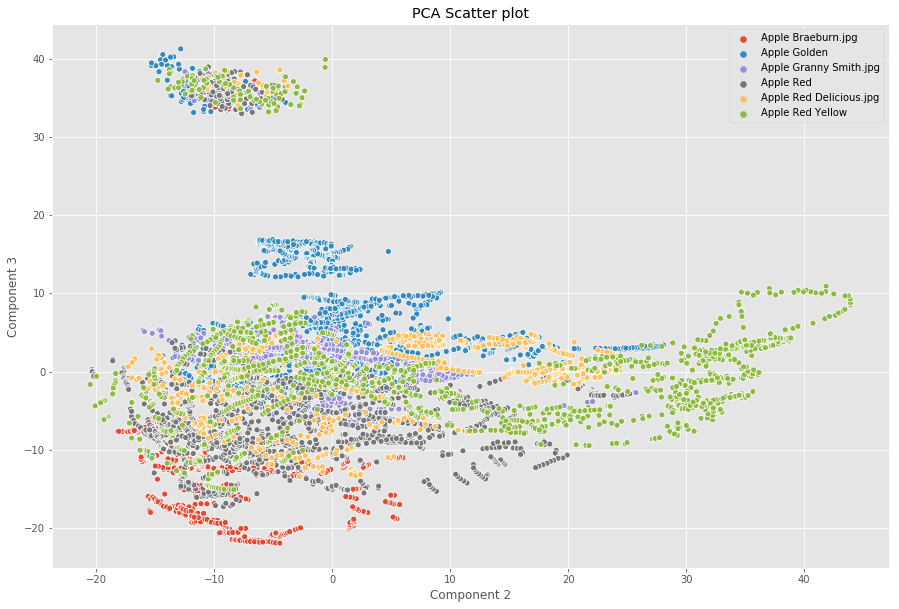

In [53]:
plt.subplots(figsize=(15,10))
sns.scatterplot(x[:,1], x[:,2], hue=apple_ok_im_dataframe['target'].values)
plt.title('PCA Scatter plot')
plt.xlabel('Component 2')
plt.ylabel('Component 3')
plt.show()

None of the components shows sgin of bein separable.

In [72]:
plt.xticks?

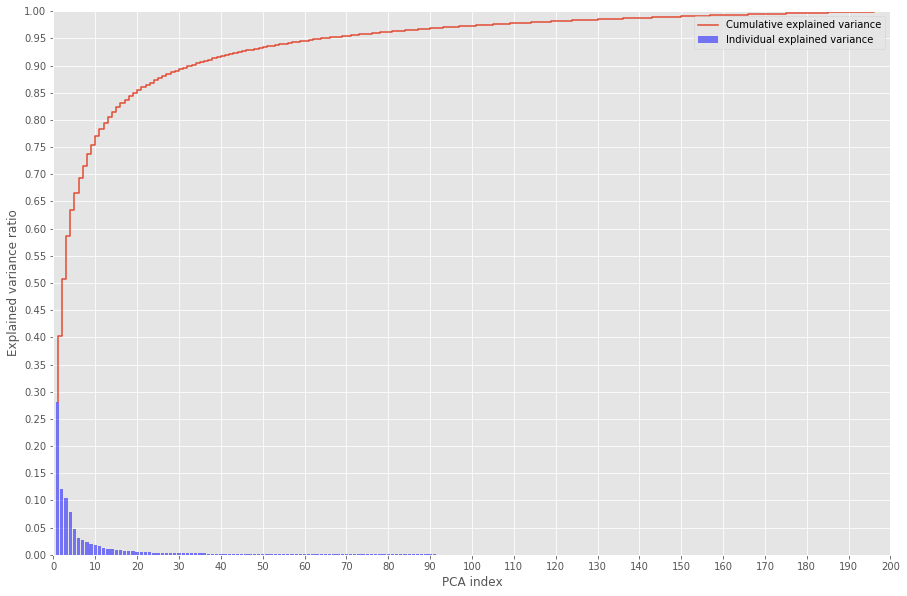

In [79]:
# Variance curve
total_variance = sum(pca_transform.explained_variance_)

exp_var = [i/total_variance for i in sorted(pca_transform.explained_variance_, reverse=True)]

cum_exp_var = np.cumsum(exp_var)

fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(range(1, 201), exp_var, label='Individual explained variance', alpha=0.5, color='blue')
ax.step(range(1, 201), cum_exp_var, label='Cumulative explained variance')
ax.set_xlabel('PCA index')
ax.set_ylabel('Explained variance ratio')
ax.set_ylim([0, 1])
ax.set_xlim([0, 200])
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_xticks(np.arange(0, 210, 10))
ax.legend(loc='best')
plt.show()

The current number of components does not ensure separability, in fact meaningful information can be extracted using over 10 components.

In [82]:
len(exp_var), len(cum_exp_var), len(range(1, 201))

(200, 200, 200)

In [55]:
# first 4 components visualization

comp1 = pca_transform.components_[0,:]
comp2 = pca_transform.components_[1,:]
comp3 = pca_transform.components_[2,:]
comp4 = pca_transform.components_[3,:]

comp1 = comp1.reshape(-1, 1)
comp2 = comp2.reshape(-1, 1)
comp3 = comp3.reshape(-1, 1)
comp4 = comp4.reshape(-1, 1)


In [56]:
mms = MinMaxScaler()

comp1_mms = mms.fit_transform(comp1)
comp2_mms = mms.fit_transform(comp2)
comp3_mms = mms.fit_transform(comp3)
comp4_mms = mms.fit_transform(comp4)

In [57]:
comp1_mms = comp1_mms.reshape(num_rows, num_cols, num_chans)
comp2_mms = comp2_mms.reshape(num_rows, num_cols, num_chans)
comp3_mms = comp3_mms.reshape(num_rows, num_cols, num_chans)
comp4_mms = comp4_mms.reshape(num_rows, num_cols, num_chans)

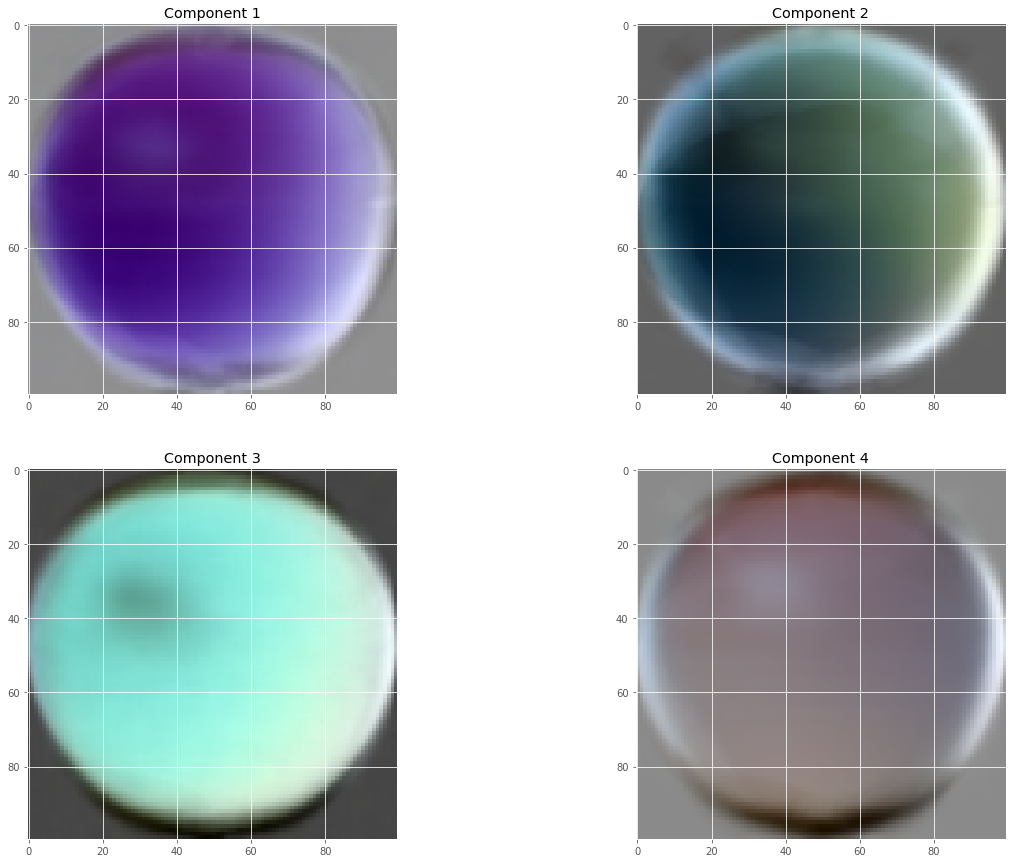

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax[0,0].imshow(comp1_mms)
ax[0,0].set_title('Component 1')
ax[0,1].imshow(comp2_mms)
ax[0,1].set_title('Component 2')
ax[1,0].imshow(comp3_mms)
ax[1,0].set_title('Component 3')
ax[1,1].imshow(comp4_mms)
ax[1,1].set_title('Component 4')
plt.show()

You should comment aftward on what you conclude from these images. Looking at the scatter plots you should see how well separated they are. Which classes do you imaging will be very easy to separate from everybody else. Which classes are so mixed that, at least with PCA, it isn't clear they are going to come apart? Write this up in your notebook.

You should also see something strange in the scatter plots. You should see dots that look like they are running along paths. This should not happen if the images were completely unrelated to each other. Paths in the PCA of dots that wander around look like time series where the images are closely related. Go back and look at sequences of images. Can you say why (write up in the notebook) these paths are clearly visible in the PCA.

Look at the line plot you did for the explained variance. How many coefficients do you need to explain around 99% of the variance? How many for 95%? 90%? What if you pick 3 compontents? What percent do we have. Discuss your results in the notebook.

Now look at the images you made of the components. What do you see? Do you see an octopus? Do you see a lighting bolt or do you see an apple-like object? What attributes look most important? Would you say that the PCA is focusing on (for theses top components) shape? Or color? Lighting? or are they trying to detect texture? Remember these images are dot-producted with the apple to come up with the projection. Speculate on what is the primary features?


### PCA on Standard Scaled Data

We are going to use StandardScalar here to bring the data in a more sensible way. It could be that the lighting might be different or the camera might sometimes be darker or lighter so this would make sense. Run X through StandardScalar via fit_transform, and give it a different name. Now make a new PCA transformer (different name) and project on 200 componets as before. Make all the same figures but make sure your titles indicate that this now has standard scaling preprocessing. Besides the PCA scatter plots, do the lineplot of the explained variance just as you did for vanalla pca, and show the images of the first 4 components.

In [59]:
ss=StandardScaler()
Xss = ss.fit_transform(X)

In [60]:
pca_transform_ss= PCA(n_components=n_components)

In [61]:
xss = pca_transform_ss.fit_transform(Xss)

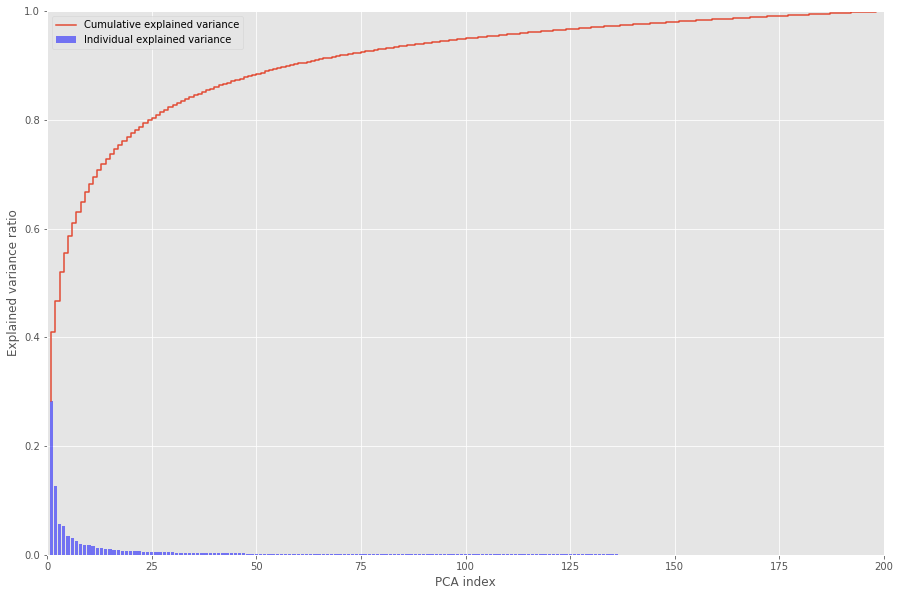

In [89]:
# Variance curve
total_variance_ss = sum(pca_transform_ss.explained_variance_)

exp_var_ss = [i/total_variance_ss for i in sorted(pca_transform_ss.explained_variance_, reverse=True)]

cum_exp_var_ss = np.cumsum(exp_var_ss)

fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(range(1, 201), exp_var_ss, label='Individual explained variance', alpha=0.5, color='blue')
ax.step(range(1, 201), cum_exp_var_ss, label='Cumulative explained variance')
ax.set_xlabel('PCA index')
ax.set_ylabel('Explained variance ratio')
ax.set_ylim([0, 1])
ax.set_xlim([0, 200])
ax.legend(loc='best')
plt.show()

In [62]:
# first 4 components visualization

comp1_ss = pca_transform_ss.components_[0,:]
comp2_ss = pca_transform_ss.components_[1,:]
comp3_ss = pca_transform_ss.components_[2,:]
comp4_ss = pca_transform_ss.components_[3,:]

comp1_ss = comp1_ss.reshape(-1, 1)
comp2_ss = comp2_ss.reshape(-1, 1)
comp3_ss = comp3_ss.reshape(-1, 1)
comp4_ss = comp4_ss.reshape(-1, 1)

In [63]:
mms_ss = MinMaxScaler()

comp1_mms_ss = mms_ss.fit_transform(comp1_ss)
comp2_mms_ss = mms_ss.fit_transform(comp2_ss)
comp3_mms_ss = mms_ss.fit_transform(comp3_ss)
comp4_mms_ss = mms_ss.fit_transform(comp4_ss)

In [64]:
comp1_mms_ss = comp1_mms_ss.reshape(num_rows, num_cols, num_chans)
comp2_mms_ss = comp2_mms_ss.reshape(num_rows, num_cols, num_chans)
comp3_mms_ss = comp3_mms_ss.reshape(num_rows, num_cols, num_chans)
comp4_mms_ss = comp4_mms_ss.reshape(num_rows, num_cols, num_chans)

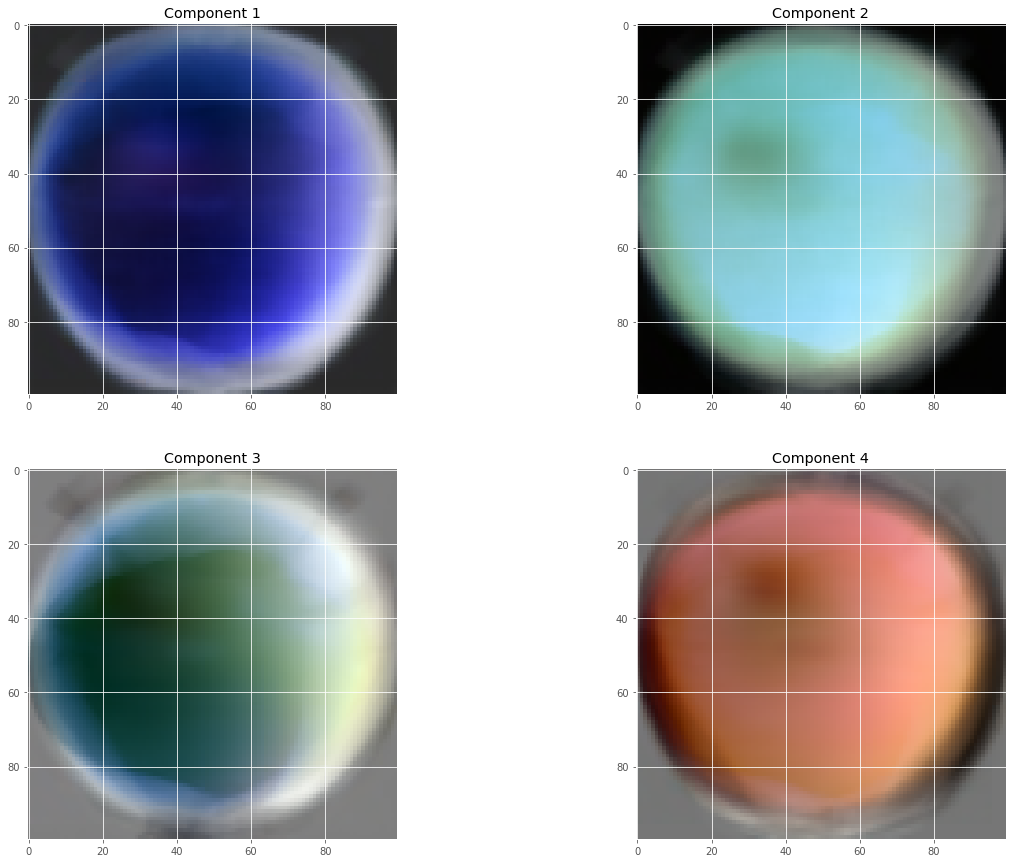

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax[0,0].imshow(comp1_mms_ss)
ax[0,0].set_title('Component 1')
ax[0,1].imshow(comp2_mms_ss)
ax[0,1].set_title('Component 2')
ax[1,0].imshow(comp3_mms_ss)
ax[1,0].set_title('Component 3')
ax[1,1].imshow(comp4_mms_ss)
ax[1,1].set_title('Component 4')
plt.show()

In [66]:
del xss

Again look at the separation, look at the explained variance and the images. What do they tell you. Did we gain anything? Is it worse? is separation a bit better or worse? Is the fall-off faster or slower? Again make sure you title and caption your figures (caption using markdown cells). This is very very important: when you write about the figure the key is not "how did I make this" but "what did we learn from this". Direct the viewer to look at an aspect of the figure, a cluster, a shape, a color .... and what it tells us about the problem. Do not just make figures and blandly say this is the first four components and move on. Nobody wants to just hear you made a plot. They want to know what this particular plot shows that some other plot of a similar type whould not show. 

### ICA on Standard Scaled Data

Lets try FastICA and see if the separation is any better. It could be or it could be worse. Lets only use n_components=3 because FastICA is much slower and we won't get as much information out. After doing the projection into 3 components, just like PCA, we are going to show projected data component 1 vs component 2, and component 2 vs component 3. Aagain show your figure and explain what you learned. How does ICA differ from PCA? Are the class more or less separated? Are some of the classes better and some worse?

In [67]:
# lotsa stuff
f_ica = FastICA(n_components=3)

In [68]:
xs = f_ica.fit_transform(Xss)

In [83]:
xs.shape

(6946, 3)

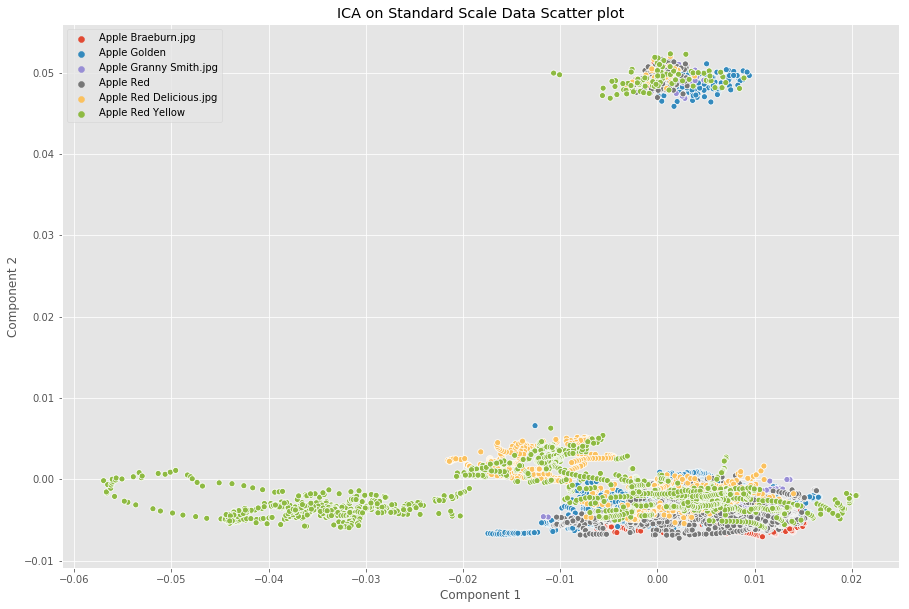

In [84]:
plt.subplots(figsize=(15,10))
sns.scatterplot(xs[:,0], xs[:,1], hue=apple_ok_im_dataframe['target'].values)
plt.title('ICA on Standard Scale Data Scatter plot')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

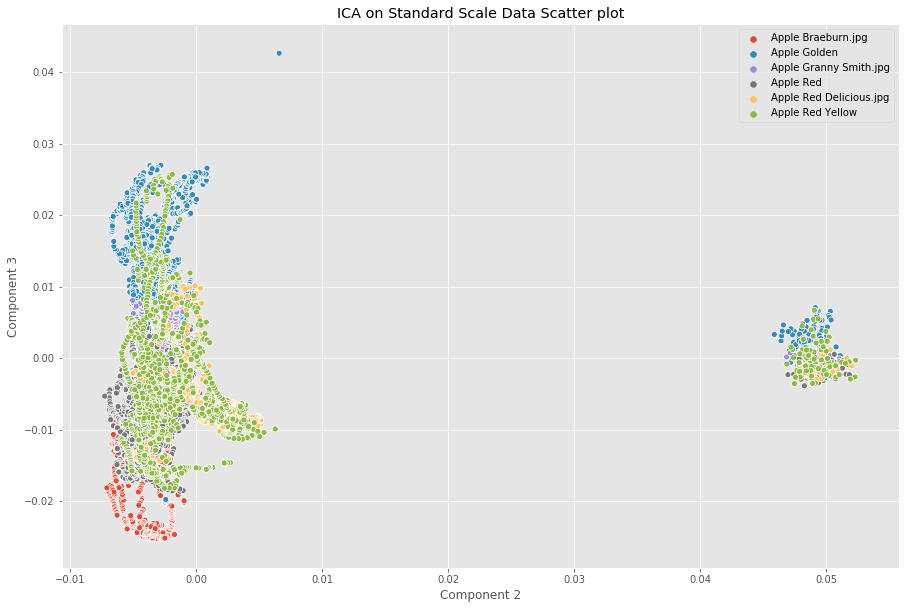

In [85]:
plt.subplots(figsize=(15,10))
sns.scatterplot(xs[:,1], xs[:,2], hue=apple_ok_im_dataframe['target'].values)
plt.title('ICA on Standard Scale Data Scatter plot')
plt.xlabel('Component 2')
plt.ylabel('Component 3')
plt.show()

Comparing the results from the first two components ICA seems to show more separability than PCA

In [86]:
# first 4 components visualization

comp1_ica = f_ica.components_[0, :]
comp2_ica = f_ica.components_[1, :]
comp3_ica = f_ica.components_[2, :]

comp1_ica = comp1_ica.reshape(-1, 1)
comp2_ica = comp2_ica.reshape(-1, 1)
comp3_ica = comp3_ica.reshape(-1, 1)

In [87]:
mms_ica = MinMaxScaler()

comp1_mms_ica = mms_ica.fit_transform(comp1_ica)
comp2_mms_ica = mms_ica.fit_transform(comp2_ica)
comp3_mms_ica = mms_ica.fit_transform(comp3_ica)


In [88]:
comp1_mms_ica = comp1_mms_ica.reshape(num_rows, num_cols, num_chans)
comp2_mms_ica = comp2_mms_ica.reshape(num_rows, num_cols, num_chans)
comp3_mms_ica = comp3_mms_ica.reshape(num_rows, num_cols, num_chans)


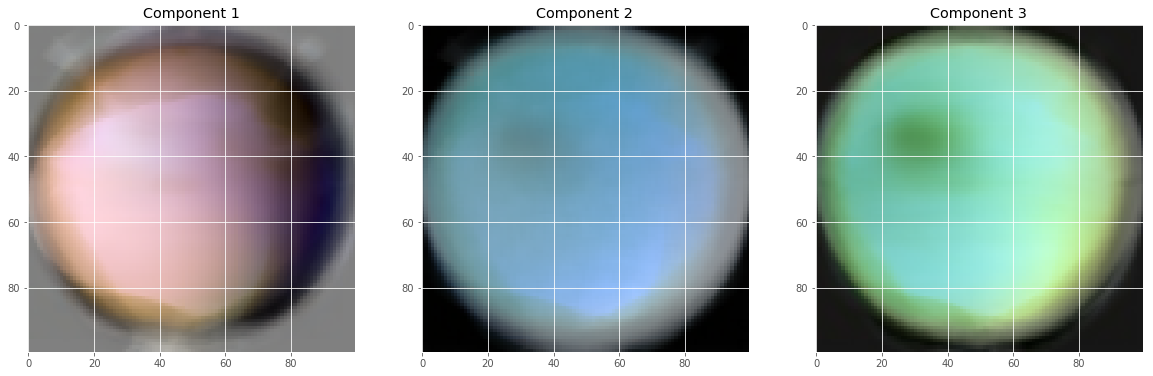

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(20, 15))
ax[0].imshow(comp1_mms_ica)
ax[0].set_title('Component 1')
ax[1].imshow(comp2_mms_ica)
ax[1].set_title('Component 2')
ax[2].imshow(comp3_mms_ica)
ax[2].set_title('Component 3')

plt.show()

In [90]:
del xs

Again you may want to free up some memeory and delete the ica tranform data.

### LDA on Standard Scaled Data

Here we are going to look at LDA. We are going to do a dimension reduction. Now you could do the LDA on the unscaled X data. You might want to try that and write up how it compares but I want you to try it on the standarded scaled X first. If you do it "right" things will go badly. After you do you fit and transform you will find a user warning: "Variables are collinear." and the figures will look bad. This happens ... we will deal with it. Again the results here are two scatter plots for LDA on X with standard scaling. Do your best to explain what happened. Linear algebra, algorithms like inverting matrices and finding eigenvalues ... often go haywire if there is colinearity and matrices are singlular.

Because we are doing LDA and using the class labels, and because we are not suppose to know the class labels in our classification problem, we must split the data into train/test sets ... lets say using test_size of 0.33, a random state of 24 and stratifying with the labels y. We then tranform and scatter plot the test set after fitting with the training set.

In [106]:
le = LabelEncoder()
y = apple_ok_im_dataframe['target'].values
y = le.fit_transform(y)

In [107]:
x_train, x_test, y_train, y_test = train_test_split(Xss, y, test_size=0.33, random_state=24, stratify=y)

In [108]:
np.unique(y_test), np.unique(y), np.unique(apple_ok_im_dataframe['target'].values)

(array([0, 1, 2, 3, 4, 5]),
 array([0, 1, 2, 3, 4, 5]),
 array(['Apple Braeburn.jpg', 'Apple Golden', 'Apple Granny Smith.jpg',
        'Apple Red', 'Apple Red Delicious.jpg', 'Apple Red Yellow'],
       dtype=object))

In [93]:
# lotsa stuff
lda = LDA()

In [94]:
# lotsa stuff
lda_train = lda.fit_transform(x_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [95]:
lda_test = lda.transform(x_test)

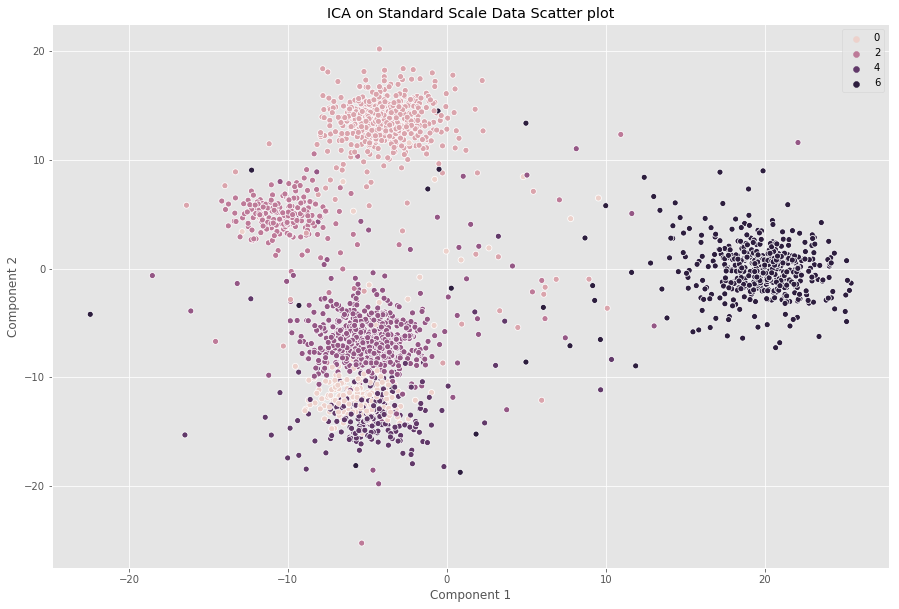

In [109]:
plt.subplots(figsize=(15,10))
sns.scatterplot(lda_test[:, 0], lda_test[:, 1], hue=y_test)
plt.title('ICA on Standard Scale Data Scatter plot')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

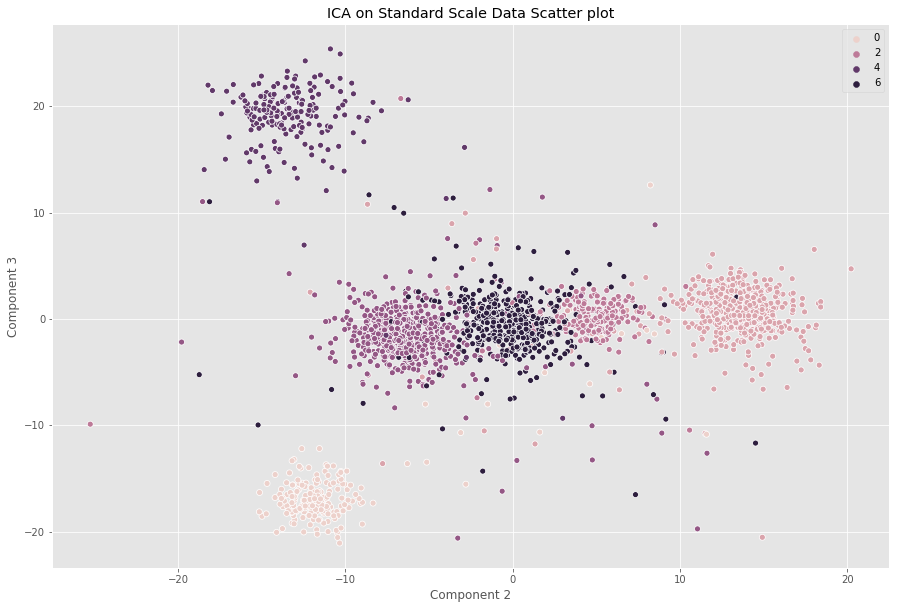

In [110]:
plt.subplots(figsize=(15,10))
sns.scatterplot(lda_test[:, 1], lda_test[:, 2], hue=y_test)
plt.title('ICA on Standard Scale Data Scatter plot')
plt.xlabel('Component 2')
plt.ylabel('Component 3')
plt.show()

Apparently LDA seems to be more separable, however three classes are missing and a new class was created. 

In [111]:
del x_train
del x_test
del y_train
del y_test

This gives us a bit of an opportunity to fix things. Recall that if the data matrix ends up having a zero eigenvalue, if, for example a covariance matrix has a zero eigenvalue ... this will make it impossible to invert the matrix. 1/0 is ... undefined. However, those are the bottom eigenvalues in PCA. Recall that PCA starts out with large eigenvalues, the ones that we believe are really relavant, and they get smaller and smaller. Finially the smallest eigenvalues correspond to directions in data space that are probably just pure noise. They don't matter. That is an assumption which is sometimes wrong but often right. Or images are 100x100 which is 10,000 dimensions. Apples don't vary **THAT** much. We see that by the time we get to 200 dimensions we probably have less than 1% variation in the scaled data. Thus we hypothesise we can dump 10,000-200 dimensions, just ignore them, and still have enough feature to separate our classes.

Note we are **not** making the strong statement that we are looking for a very small number of crutial features for class separation. Rather we are making the much weaker statement that there are many many independent dimenensions which are irrelavant to our problem (separating a golden apple from a granny smith) and we can throw a whole bunch of low variance data without losing anything.


### PCA as a preprocessing for LDA

We are going to project PCA on 200 components and THEN do LDA and see if this helps. It should help with colinearity because those are exactly the small eigenvalue dimensions. Do the analysis you did for LDA but instead of using the scaled X use the scaled X projected into 200 dimensions that you computed in the PCA section. Again we will need to do a train test split here. Since you probably got a mess last time (even if you play with the random seed) we will just do over the split but working with the projected standard scaled X. The y is not projected since that is just the corresponding labels.

Because the LDA is a bit different from PCA, your scatter plots should show a bit more ... LDA component 1 vs 2, LDA component 2 vs 3 and LDA component 1 vs 3 and also 3 vs 4. This should look better. Remember this is using labels (at least from the training set) to find projections which spread things out well. Write up what you see. Again we don't have the explained variance plots here and although we could make them, I am not asking you to make the component images.

In [112]:
# lotsa stuff
pca = PCA(n_components=200)

In [113]:
xss = pca.fit_transform(Xss)

In [114]:
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(xss, y, test_size=0.33, 
                                                                    random_state=24, stratify=y)

In [115]:
lda = LDA()

In [116]:
lda_tr = lda.fit_transform(x_train_pca, y_train_pca)

In [117]:
lda_ts = lda.transform(x_test_pca)

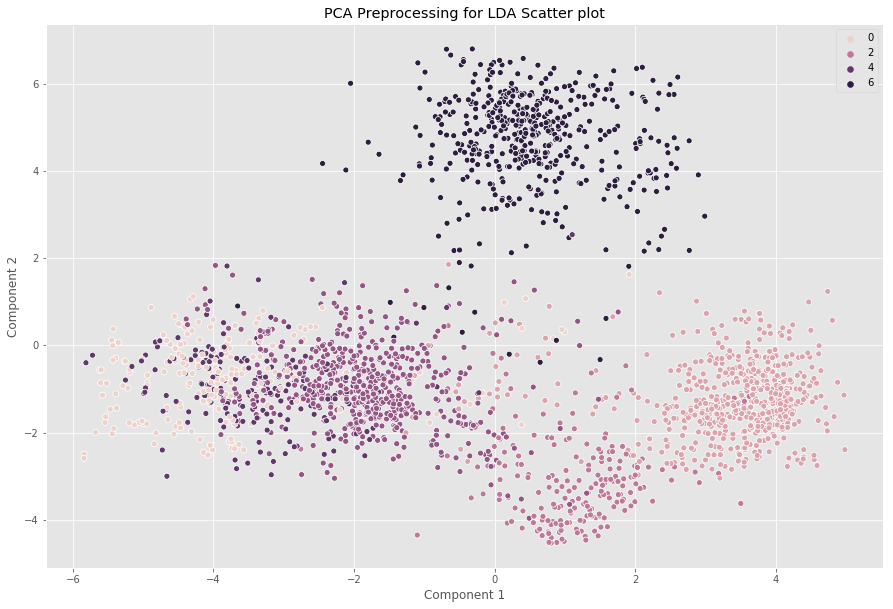

In [118]:
plt.subplots(figsize=(15,10))
sns.scatterplot(lda_ts[:, 0], lda_ts[:, 1], hue=y_test_pca)
plt.title('PCA Preprocessing for LDA Scatter plot')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

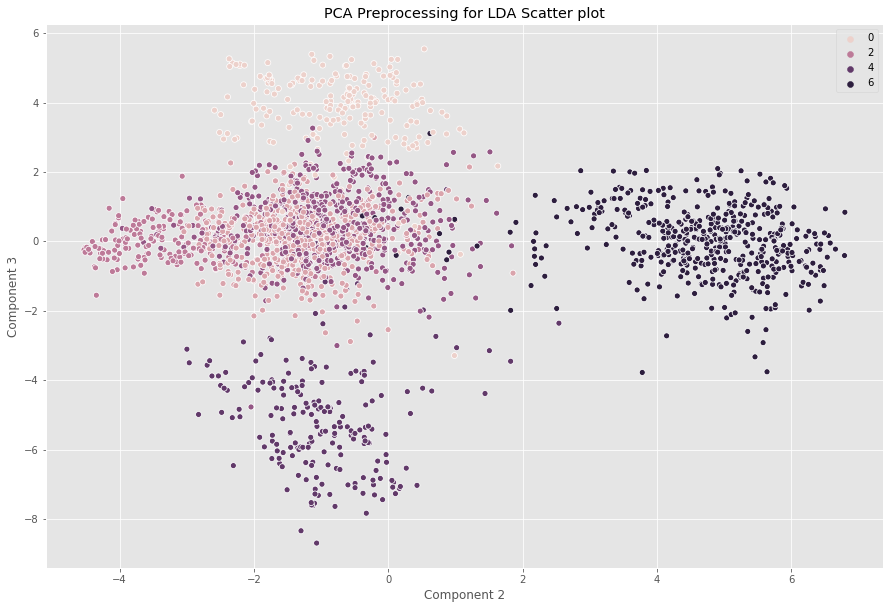

In [119]:
plt.subplots(figsize=(15,10))
sns.scatterplot(lda_ts[:, 1], lda_ts[:, 2], hue=y_test_pca)
plt.title('PCA Preprocessing for LDA Scatter plot')
plt.xlabel('Component 2')
plt.ylabel('Component 3')
plt.show()

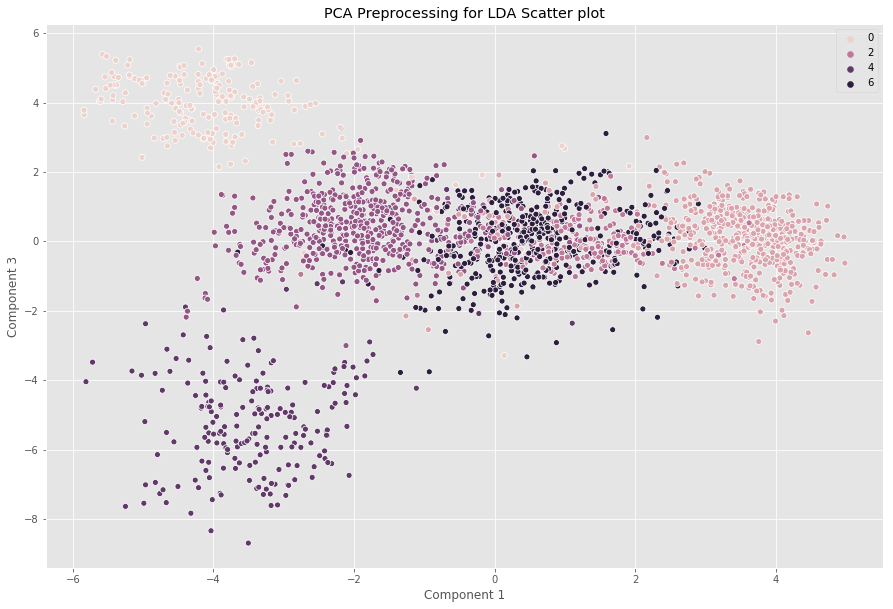

In [120]:
plt.subplots(figsize=(15,10))
sns.scatterplot(lda_ts[:, 0], lda_ts[:, 2], hue=y_test_pca)
plt.title('PCA Preprocessing for LDA Scatter plot')
plt.xlabel('Component 1')
plt.ylabel('Component 3')
plt.show()

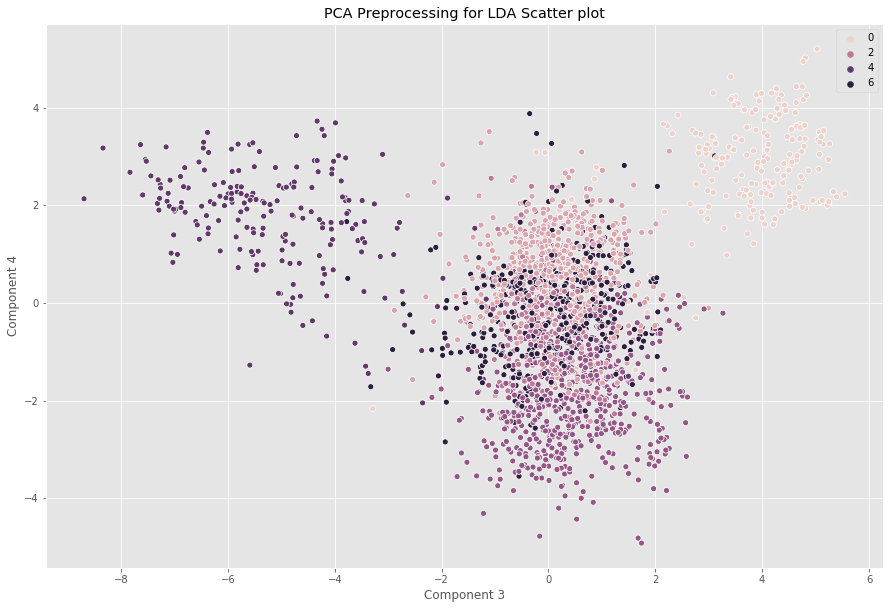

In [121]:
plt.subplots(figsize=(15,10))
sns.scatterplot(lda_ts[:, 2], lda_ts[:, 3], hue=y_test_pca)
plt.title('PCA Preprocessing for LDA Scatter plot')
plt.xlabel('Component 3')
plt.ylabel('Component 4')
plt.show()

Does LDA do a better job than PCA at separation?

It may!!



### Dimension Reduction with T-SNE

We made a big deal about how T-SNE can work wonders. This will take time and memory. Again put in put in the pca_projected standard scaled space. Do it with random state 42 and random state 24 on fit transform looking at 2 components and, as above, coloring with the labels (all y) even though the TSNE algorithm doesn't use the labels. Our question is that given T-SNE doesn't know the labels.

In [122]:
# lotsa stuff
pca = PCA(n_components=200, random_state=42)

xs = pca.fit_transform(Xss)

In [103]:
tsne = TSNE(n_components=2, random_state=24)
xss = tsne.fit_transform(xs)

In [98]:
xss.shape

(6946, 2)

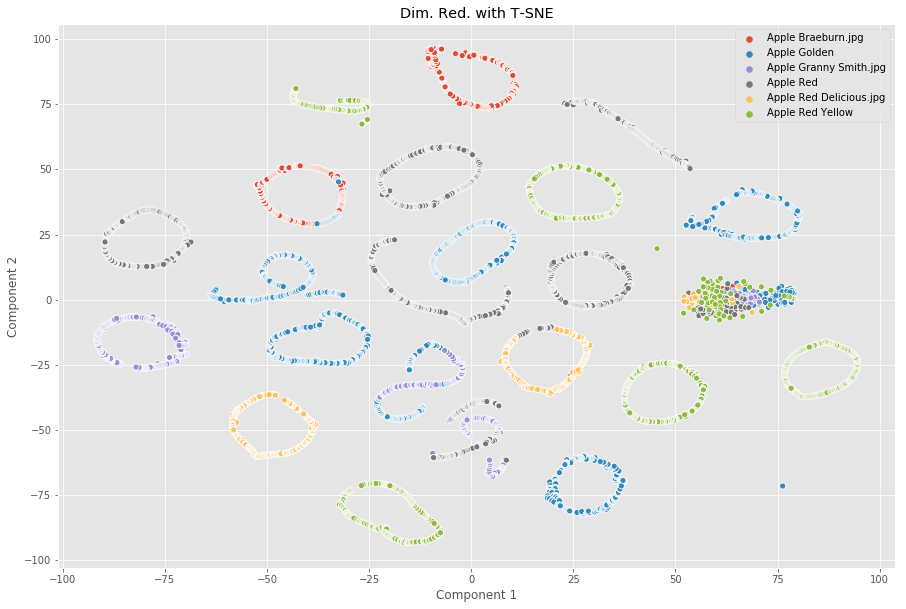

In [102]:
plt.subplots(figsize=(15, 10))
sns.scatterplot(xss[:,0], xss[:,1], hue=apple_ok_im_dataframe['target'].values)
plt.title("1st Trial-Dim. Red. with T-SNE")
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

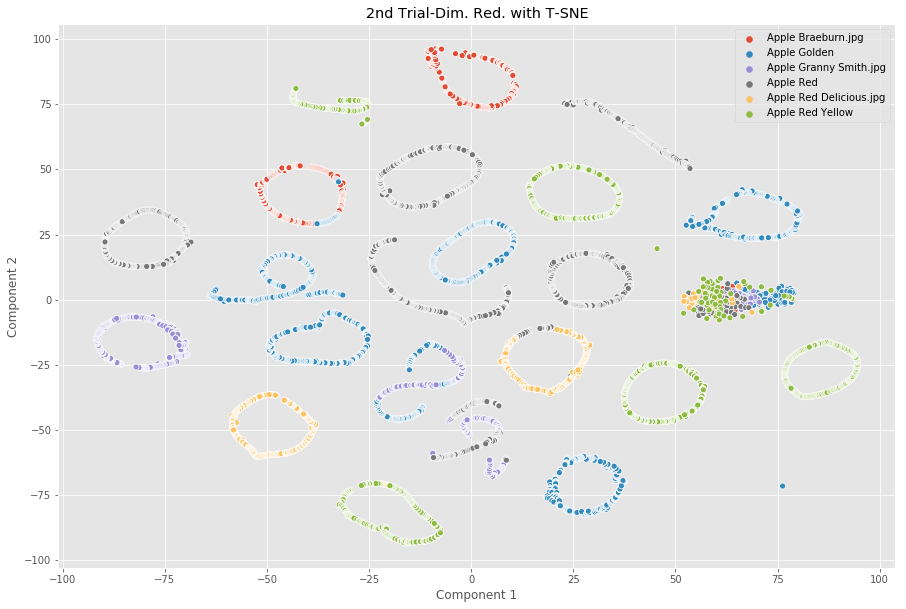

In [104]:
plt.subplots(figsize=(15, 10))
sns.scatterplot(xss[:,0], xss[:,1], hue=apple_ok_im_dataframe['target'].values)
plt.title("2nd Trial-Dim. Red. with T-SNE")
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Did TSNE find the clusters? Did it fewer clusters? Did it find more? Running it twice do we get the same answer? Again do see paths in the data as we did before? Are they any different? Rember we don't have a transform that we can reuse. If it did show us structure in the data, how might that help us even though we don't have a way of transforming new data the same way?

TSNE found most clusters with the exception of some minor errors. It found more clusters than PCA, IDA, and LDA. To reuse the clusters on new data, we can train a KNN which memorizes the position for each cluster.

## Classification Results with Dimension Reduction

We originally said we would use these images for automatic classification. LDA is a dimension reduction algorithm but it is also a classficication algorithm. Lets apply that and random forest and see what happens as we increase or degrese the dimensions we work with.

### LDA Classification Results 

We are now working with the data, just like above, which was fit on X standard scaled, and projected into 200 dimensions using PCA. We already did the training test split. We already should have an LDA fit on training data. Instead of using the transform method above, use the predict method on the test data. Now we will print the accuracy score and the classification score.

In [114]:
# lotsa stuff
lda_pred = lda.predict(x_test_pca)

In [115]:
accuracy_score(lda_pred, y_test_pca)

0.951155691234191

In [116]:
print(classification_report(lda_pred, y_test_pca))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       190
           1       0.95      0.96      0.95       603
           2       0.93      0.89      0.91       214
           3       0.96      0.92      0.94       617
           4       0.95      0.99      0.97       193
           5       0.97      0.98      0.97       476

   micro avg       0.95      0.95      0.95      2293
   macro avg       0.95      0.96      0.95      2293
weighted avg       0.95      0.95      0.95      2293



These numbers should be pretty spectacular. You should be very close to 100 nearly accross the board. There are a number of reasons for this. This is an "easy problem". The apples have many attributes that help us distinguish them and for the training and testing set color alone is pretty good. Even with our training and testing we are overfitting in the extreme. Most of the images are of the same apple. For each class we only have a couple of actual samples, the images are just different views. When we do our training we are getting training on different views of the same apple we are testing on. If we wanted more realistic numbers we chould only include, for example, "Apple Red 1" completely in training or testing and the other sample in the other. We would also want to have hundreds of samples of apples rather than hundreds of views of the same apple. This is, in the end a pretty lousy classification set despite the large number of images.

### PCA 100, 50, 25, 5, 2 pre-processing of LDA

All that being said, it is interesting that we got such good results going from 10,000 dimensions down to 200. How far can we go. We know that as we go from 200 to 1, our performance will drop. How fast? In this section you will just perform LDA over and over (remember to greate a different LDA() object, different variable name) for each experiment. Try doing LDA where we only use 100, 50, 25, and 2 components. Show the accuracy score and the classification report. Which classes are hard to separate. How do they agree or disagree with what you saw in the first PCA components. By the time we get down to 2D how bad are things. 

With each run, note some set of numbers which are interesting. What did you learn from that run.

### Features vs. Classification Alg

So reversing what we just did, all things being equal, the more features we have, the better our classification accuracy should be. Again, this will not always be the case but particularly as we increase the number of features starting at 1, and for simlar kinds of features (like pixels) this should generally hold. We only condidered a linear classifier LDA. Instead we could look at a non-linear classifier like RandomForest. In general, classes need not be linearly seperable so we should see better peformance for RandomForest than for LDA, again all things being equal. Lets see how much performance increases for the worst cases PCA projected into 5 and 2 dimensions. Run again and print the accuracy score and comment how they compare to LDA.

In [ ]:
# lotsa stuff